# Credit Card Fraud Detection Predictive Models
#### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. So in this project, we will Build a machine learning model to identify fraudulent credit card transactions.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 100)

In [2]:
# Read the data

raw_df = pd.read_csv('C:/Users/apple/Desktop/study/project/codsoft/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - Class. 

###  Data imbalance check

In [3]:
# Let's look at the distribution of target.

vc = raw_df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["count"].apply(lambda x : round(100*float(x) / len(raw_df), 2))
vc

,Class,count,percent
0,0,284315,99.83
1,1,492,0.17


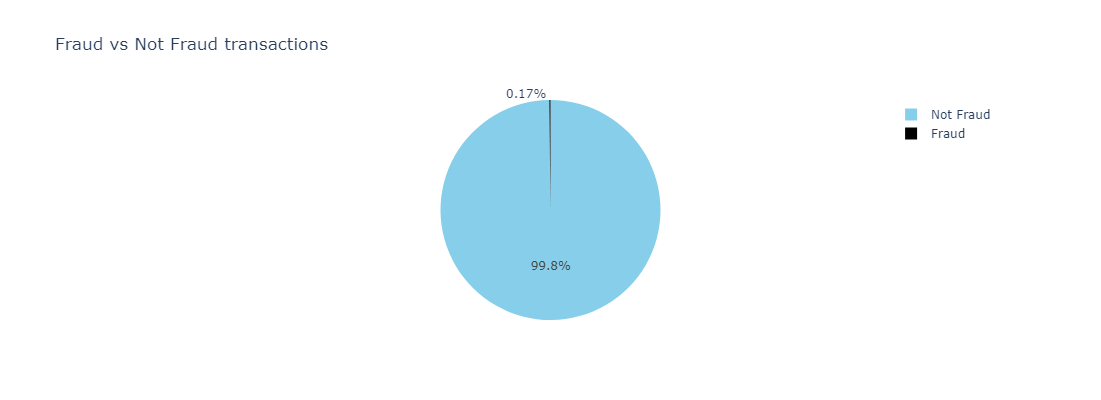

In [4]:
labels=["Not Fraud","Fraud"]
fig = px.pie(values=vc['percent'], names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Not Fraud transactions")
fig.show()

#### One of the biggest challenge of this problem is that the target is highly imbalanced as only 0.17 % cases are fraud transactions. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud.

### Data pre-processing

In [5]:
df=raw_df.copy()
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.duplicated().sum()

1081

In [7]:
#  Dropping duplicated values

df.drop_duplicates(inplace=True)

In [8]:
# Check null values

df.isnull().sum().max()

0

### EDA

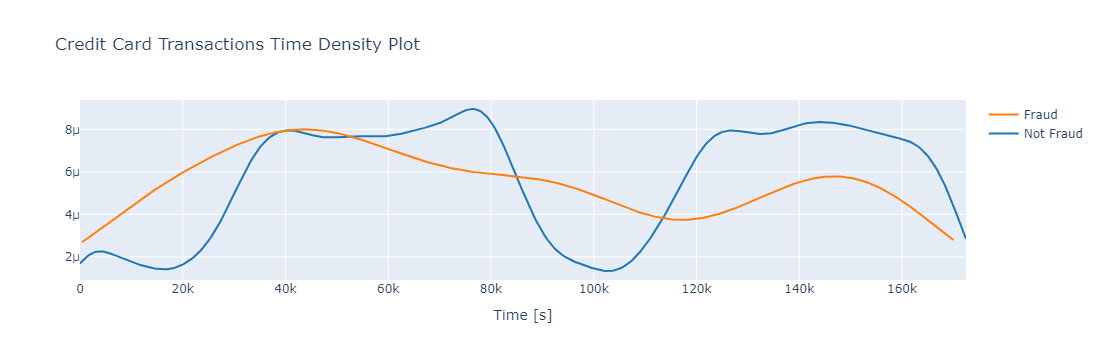

In [9]:
# line plot

class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

#### Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

In [10]:
# check more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour.

df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df1 = pd.DataFrame(tmp)
df1.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df1.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3929,255825.95,65.112230,12.990,45961.838558
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2211,145744.59,65.917951,23.000,20085.295527
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1552,106983.39,68.932597,17.985,45434.509936


C:\Users\apple\anaconda3\anzh\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\apple\anaconda3\anzh\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\apple\anaconda3\anzh\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\apple\anaconda3\anzh\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



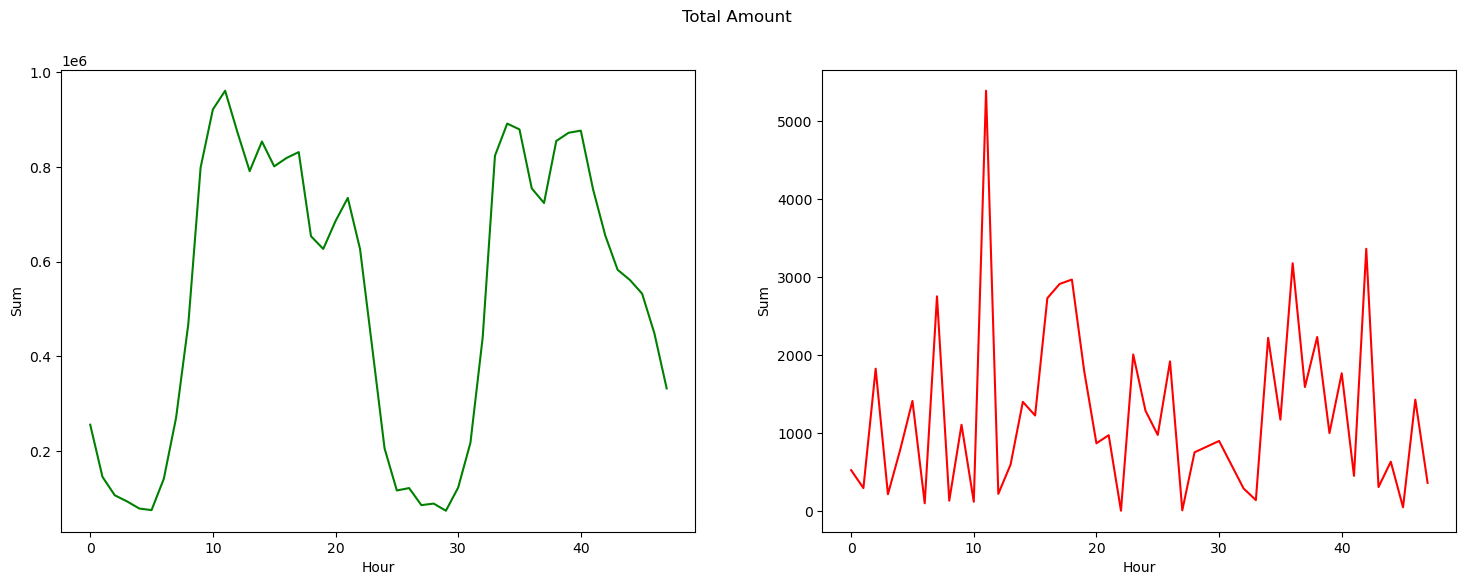

In [11]:
# line plot

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df1.loc[df1.Class==0], color="green")
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df1.loc[df1.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show()

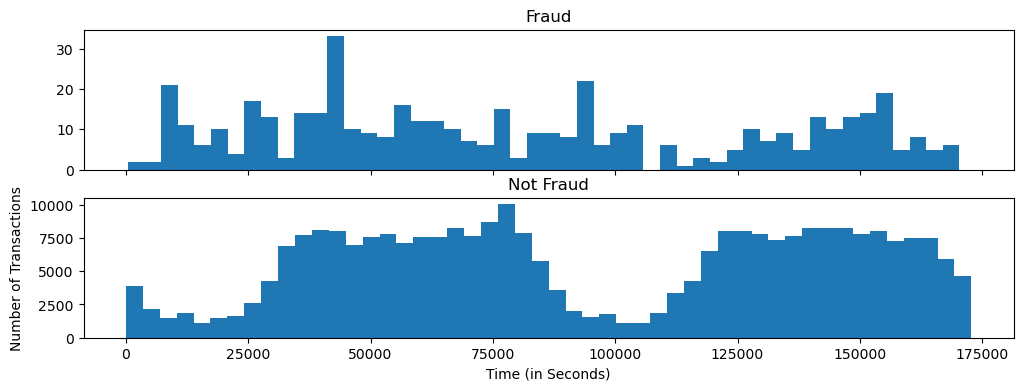

In [12]:
# hist plot

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Not Fraud')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

### Random Under Sampling
#### In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

In [13]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
13244,23298.0,1.189307,0.577716,0.838174,2.824436,0.064283,0.210563,-0.073087,-0.130154,0.938514,0.111661,-0.306044,-1.850856,2.826686,0.975894,-1.731952,0.154063,0.334195,-0.234720,-0.641371,-0.119091,-0.246985,-0.216829,-0.147177,-0.128807,0.708367,0.065750,-0.011408,0.012033,7.81,0,6.0
59539,48884.0,-2.139051,1.394368,-0.612035,1.049327,-1.162102,-0.768219,-1.997237,0.574997,-0.980832,-2.495619,2.555589,-3.530436,-1.016234,-3.455197,-0.056363,-2.467737,-7.140326,-1.271280,-0.001722,0.025427,0.696955,0.740003,-0.155115,-0.050607,0.268368,-0.469433,-0.405814,-0.152171,19.73,1,13.0
10498,17230.0,-0.469327,1.111453,2.041003,1.731595,0.135147,-0.093625,0.266155,0.082988,0.580255,-0.164563,0.500376,-3.021760,0.924213,1.500794,-0.400283,0.706048,0.115114,-0.046796,-2.548522,-0.358709,0.159387,0.592670,-0.053596,0.320748,-0.369121,-0.136605,-0.100845,0.039347,3.93,1,4.0
192584,129764.0,-2.434004,3.225947,-6.596282,3.593161,-1.079452,-1.739741,-0.047420,0.301424,-1.779434,-5.836453,3.249431,-5.961488,-1.155176,-11.002289,0.588286,-2.365801,-1.351900,0.189498,0.524008,-0.280533,-0.035491,-0.419178,0.157436,-0.714849,0.468859,-0.348522,0.420036,-0.327643,362.55,1,36.0
82400,59385.0,-7.626924,-6.976420,-2.077911,3.416754,4.458758,-5.080408,-6.578948,1.760341,-0.599509,-4.001742,2.611762,-2.210691,0.145323,-5.281678,-1.446227,-2.342178,-4.442082,-0.812202,0.254772,2.875260,1.224795,-0.656639,-0.330811,-0.078946,0.270306,0.431119,0.821381,-1.056088,18.98,1,16.0


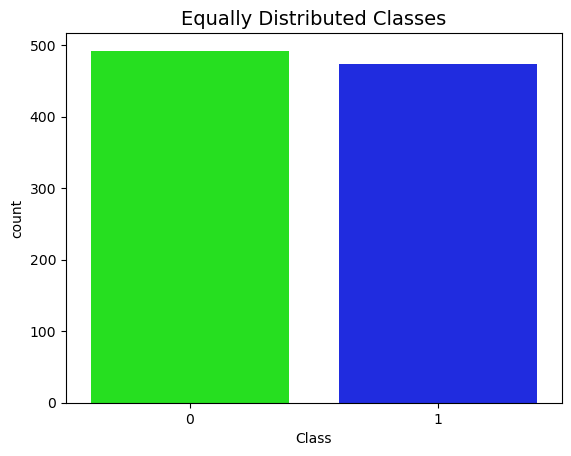

In [14]:
new_df['Class'].value_counts()/len(new_df)

sns.countplot(x='Class', data=new_df, palette='hsv')
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Correlation Matrices#### 
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. 

In [15]:
X = df.drop('Class', axis=1)
y = df['Class']
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
clf1 = LogisticRegression(solver="lbfgs").fit(X_train, y_train)
pred_y = clf1.predict(X_test)
print ("Classification Report: ")
print (classification_report(y_test, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(y_test, pred_y))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56662
           1       0.69      0.64      0.67        84

    accuracy                           1.00     56746
   macro avg       0.85      0.82      0.83     56746
weighted avg       1.00      1.00      1.00     56746


Accuracy Score:  0.999048391076023


C:\Users\apple\anaconda3\anzh\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [17]:
clf2 = RandomForestClassifier(verbose=False).fit(X_train, y_train)
pred_y = clf2.predict(X_test)
print ("Classification Report: ")
print (classification_report(y_test, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(y_test, pred_y))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56662
           1       0.89      0.75      0.81        84

    accuracy                           1.00     56746
   macro avg       0.94      0.87      0.91     56746
weighted avg       1.00      1.00      1.00     56746


Accuracy Score:  0.9994889507630493


In [18]:
clf3 = DecisionTreeClassifier(criterion='entropy',max_depth=3).fit(X_train, y_train)
pred_y = clf3.predict(X_test)
print ("Classification Report: ")
print (classification_report(y_test, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(y_test, pred_y))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56662
           1       0.79      0.79      0.79        84

    accuracy                           1.00     56746
   macro avg       0.89      0.89      0.89     56746
weighted avg       1.00      1.00      1.00     56746


Accuracy Score:  0.999365594050682


#### All the accuracy score is more then 99%, the high accuracy is trivial on an imbalanced classification problem. So accuracy never helps in imbalanced dataset. We use recall as metric for imbalanced datasets. The dicision tree model is better.

####  To solving class imbalance problem before starting classification, we can use random resampling methods. There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling. Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class. Oversampling is the most often used approach (but not necessarily the best).

### Random oversampling
#### The random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples. 

In [20]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)
# fit and apply the transform
X_over, y_over = ros.fit_resample(X_train, y_train)
print('Not Fraud:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Not Fraud: 226591 / 50.0 % of the dataset
Frauds: 226591 / 50.0 % of the dataset


### Random undersampling

In [21]:
from imblearn.under_sampling import RandomUnderSampler
# define oversampling strategy
rus = RandomUnderSampler(random_state=42)
# fit and apply the transform
X_under, y_under = rus.fit_resample(X_train, y_train)
print('Not Fraud:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Not Fraud: 389 / 50.0 % of the dataset
Frauds: 389 / 50.0 % of the dataset


#### With our dataset after undersampling we have only 389 record so it's not the best idea to take advantage of that technique.